In [1]:
import os
import time
import csv
import signal
import random
import itertools
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, TimeoutError
from rasengan.problems.facility_location_problem import generate_flp
import numpy as np
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    PenaltySolver, ChocoSolver, RasenganSolver,
    AerGpuProvider, AerProvider, DdsimProvider,
)

np.random.seed(0x7f)
random.seed(0x7f)

In [2]:
num_cases = 10

flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases, [(1, 2)], 1, 10)

In [3]:
csv_path = "more_layers_qaoa.csv"

problems_pkg = list(
    itertools.chain(
        enumerate(flp_problems_pkg),
    )
)

solvers = [ChocoSolver, PenaltySolver, RasenganSolver]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics
num_layers_list = range(1, 21, 1)

def process_layer(prb, num_layers, solver):
    opt = CobylaOptimizer(max_iter=1000)
    aer = DdsimProvider()
    cpu = AerProvider()
    gpu = AerGpuProvider()
    prb.set_penalty_lambda(400)
    used_solver = solver(
        prb_model = prb,
        optimizer = opt,
        # provider = gpu if solver in [HeaSolver, PenaltySolver] else aer,
        provider = cpu if solver in [PenaltySolver] else aer,
        num_layers = num_layers,
        shots = 1024,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]

if __name__ == '__main__':
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    with open(f'{csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    # pkid-pbid: 问题包序-包内序号
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for layer in tqdm(num_layers_list, desc="Evaluating across num_layers"):
            for solver in solvers:
                num_processes = 100

                if solver == RasenganSolver and layer > 1:
                    continue

                with ProcessPoolExecutor(max_workers=num_processes) as executor:
                    futures = []
                    # layer = 5
                    for pbid, prb in enumerate(problems):
                        # print(f'{pkid}-{pbid}, {layer}, {solver} build')
                        future = executor.submit(process_layer, prb, layer, solver)
                        futures.append((future, prb, pkid, pbid, layer, solver.__name__))

                    start_time = time.perf_counter()
                    for future, prb, pkid, pbid, layer, solver in futures:
                        current_time = time.perf_counter()
                        remaining_time = max(set_timeout - (current_time - start_time), 0)
                        diff = []
                        try:
                            metrics = future.result(timeout=remaining_time)
                            diff.extend(metrics)
                            # print(f"Task for problem {pkid}-{pbid} L={layer} {solver} executed successfully.")
                        except MemoryError:
                            print(f"Task for problem {pkid}-{pbid} L={layer} {solver} encountered a MemoryError.")
                            for dict_term in evaluation_metrics:
                                diff.append('memory_error')
                        except TimeoutError:
                            print(f"Task for problem {pkid}-{pbid} L={layer} {solver} timed out.")
                            for dict_term in evaluation_metrics:
                                diff.append('timeout')
                        except Exception as e:
                            print(f"An error occurred: {e}")
                        finally:
                            row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), solver] + diff
                            with open(f'{csv_path}', mode='a', newline='') as file:
                                writer = csv.writer(file)
                                writer.writerow(row)  # Write row immediately
                            num_complete += 1
                            if num_complete == len(futures):
                                # print(f'problem_pkg_{pkid} has finished')
                                for process in executor._processes.values():
                                    os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating across num_layers: 100%|██████████| 20/20 [24:15<00:00, 72.75s/it] 

Data has been written to more_layers_qaoa.csv
Time elapsed: 1455.10s


In [4]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列

df = pd.read_csv(csv_path)

rasengan_arg = df.query("method == 'RasenganSolver' and layers == 1")['ARG'].mean()

grouped_df = df.groupby(['pkid', 'layers', 'variables', 'constraints', 'method'], as_index=False).agg({
    'iteration_count':'mean',
    'classcial':'mean',
    'run_times':'mean',
    "ARG": 'mean',
    'in_constraints_probs': 'mean',
    'best_solution_probs': 'mean',
})

pivot_df = grouped_df.pivot(index =['pkid', 'layers', 'variables', 'constraints'], columns='method', values=["ARG", 'best_solution_probs', 'classcial', 'run_times','iteration_count'])
method_order = ['PenaltySolver', 'ChocoSolver', 'RasenganSolver']
pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_product([["ARG", 'best_solution_probs', 'run_times', 'iteration_count', 'classcial'], method_order]))

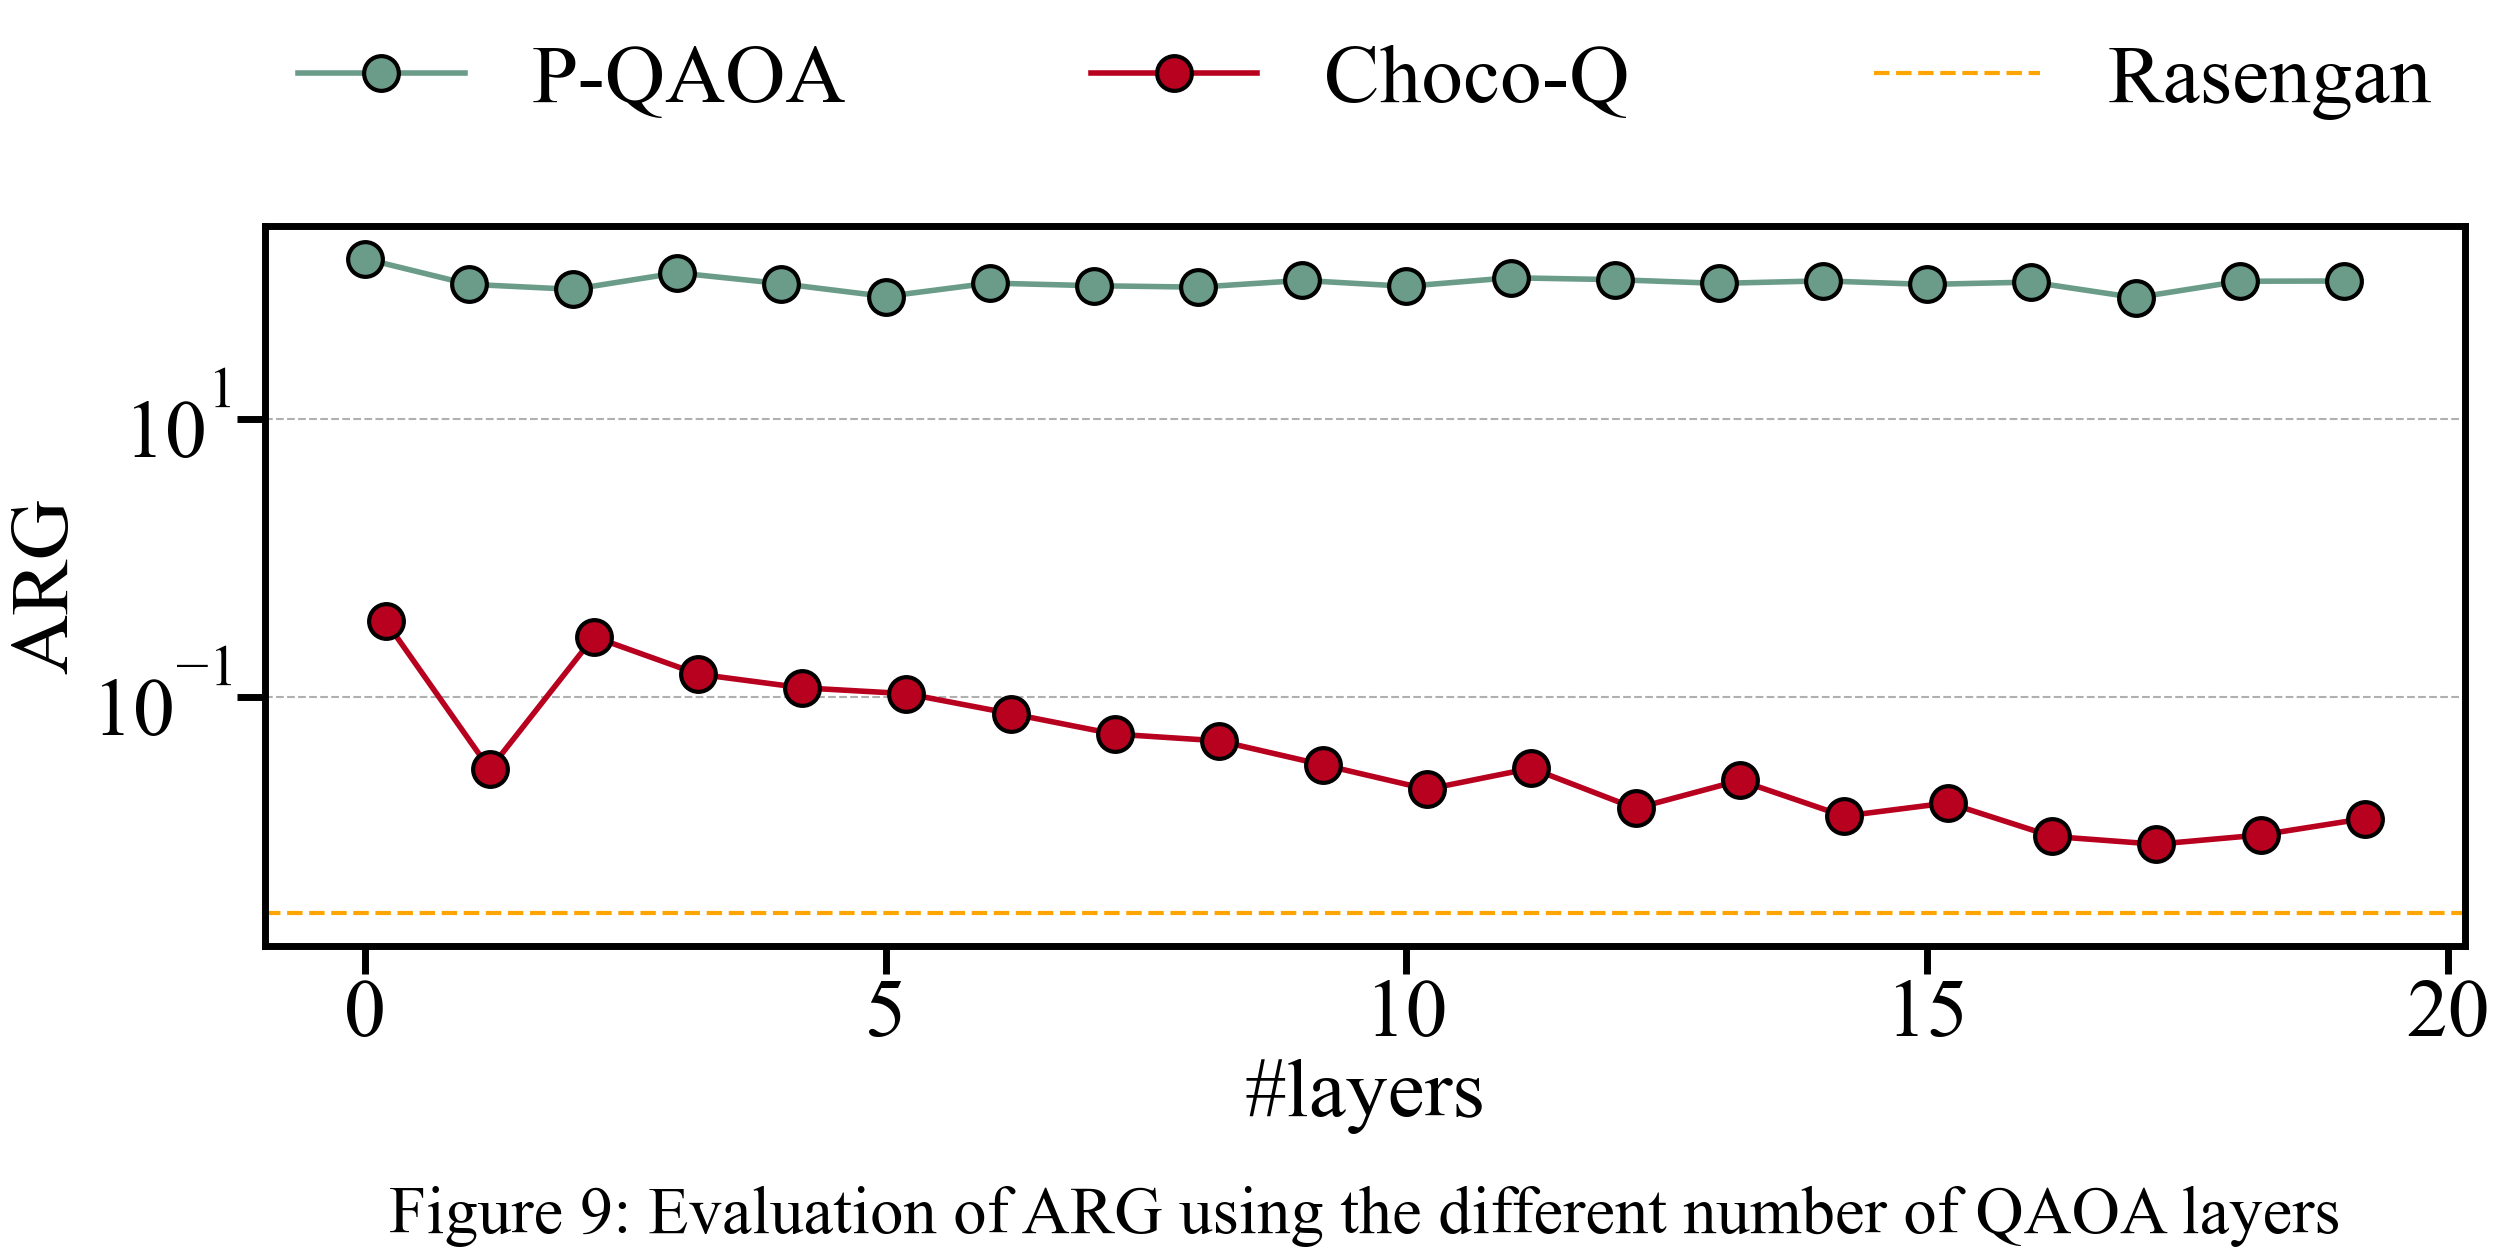

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

df = pd.read_csv("more_layers_qaoa.csv")
grouped_df = df.groupby(['pkid', 'layers', 'variables', 'constraints', 'method'], as_index=False).agg({
    'ARG': 'mean'
})
rasengan_arg = df.query("method == 'RasenganSolver' and layers == 1")['ARG'].mean()

scale = 1
fig = plt.figure(figsize=(22*scale, 12*scale))
mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

ax = plt.axes((0, 0, 1, 0.6))

colors = ['#6A9C89', '#B8001F']
labels = ['P-QAOA', 'Choco-Q']

for idx, method in enumerate(['PenaltySolver', 'ChocoSolver']):
    data = grouped_df[grouped_df.method == method]
    x = np.arange(len(data.pkid))
    y = data['ARG'].to_list()
    ax.plot(x + idx * 0.2, y, marker='o', markersize=25, color=colors[idx], label=labels[idx],
            linestyle='-', linewidth=4, markeredgewidth=3, markerfacecolor=colors[idx], markeredgecolor='black')

ax.axhline(y=rasengan_arg, color='orange', linestyle='--', linewidth=3, label='Rasengan')

ax.grid(True, linestyle='--', linewidth=1.5, axis='y')

plt.yscale('log')
plt.xlabel('#layers')
plt.ylabel('ARG')
plt.legend(loc='upper left', ncol=3, frameon=False, bbox_to_anchor=(0, 1.1, 1, 0.2), mode="expand", borderaxespad=0)

title = 'Figure 9: Evaluation of ARG using the different number of QAOA layers'
plt.suptitle(title, y=-0.2, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()